# 变分量子奇异值分解 (VQSVD)

<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>


## 概览

在本教程中，我们一起学习下经典奇异值分解（SVD）的概念以及我们自主研发的量子神经网络版本的量子奇异值分解 （VQSVD，Variational Quantum Singular Value Decomposition）[1] 是如何运作的。主体部分包括两个具体案例：

- 分解随机生成的 8x8 复数矩阵
- 应用在图像压缩上的效果

## 背景

奇异值分解（SVD）有非常多的应用包括 -- 主成分分析（PCA）、求解线性方程组和推荐系统。其主要任务是给定一个复数矩阵 $M \in \mathbb{C}^{m \times n}$, 找到分解形式：

$$
M = UDV^\dagger
$$

其中 $U_{m\times m}$ 和 $V^\dagger_{n\times n}$ 是酉矩阵（Unitary matrix）, 满足性质 $UU^\dagger = VV^\dagger = I$。 
- 矩阵 $U$ 的列向量 $\lvert {u_j}\rangle$ 被称为左奇异向量（left singular vectors）, $\{\lvert {u_j}\rangle\}_{j=1}^{m}$ 组成一组正交向量基。这些列向量本质上是矩阵 $MM^\dagger$ 的特征向量。
- 类似的，矩阵 $V$ 的列向量 $\{\lvert {v_j}\rangle\}_{j=1}^{n}$ 是 $M^\dagger M$ 的特征向量也组成一组正交向量基。
- 中间矩阵 $D_{m\times n}$ 的对角元素上存储着由大到小排列的奇异值 $d_j$。 

我们不妨先来看个简单的例子：（为了方便讨论，我们假设以下出现的 $M$ 都是方阵）

$$
M = 2*X\otimes Z + 6*Z\otimes X + 3*I\otimes I = 
\begin{bmatrix} 
3 &6 &2 &0 \\
6 &3 &0 &-2 \\
2 &0 &3 &-6 \\
0 &-2 &-6 &3 
\end{bmatrix}
$$

那么该矩阵的奇异值分解可表示为:

$$
M = UDV^\dagger = 
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &1 &1 \\
-1 &-1 &-1 &-1 \\
-1 &1 &-1 &1 \\
1 &-1 &-1 &1 
\end{bmatrix}
\begin{bmatrix} 
11 &0 &0 &0 \\
0 &7 &0 &0 \\
0 &0 &5 &0 \\
0 &0 &0 &1 
\end{bmatrix}
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &-1 &-1 \\
-1 &-1 &1 &1 \\
-1 &1 &1 &-1 \\
1 &-1 &1 &-1 
\end{bmatrix}
$$

首先，让我们通过下面几行代码引入必要的 library和 package。

In [1]:
import time
import numpy as np
from progressbar import ProgressBar
from matplotlib import pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import norm

import paddle.fluid as fluid
from paddle.complex import matmul, transpose, trace
from paddle_quantum.circuit import *
from paddle_quantum.utils import *


# 画出优化过程中的学习曲线
def loss_plot(loss):
    '''
    loss is a list, this function plots loss over iteration
    '''
    plt.plot(list(range(1, len(loss)+1)), loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss Over Iteration')
    plt.show()


## 经典奇异值分解

那么在了解一些简单的数学背景之后， 我们来学习下如何用 Numpy 完成矩阵的奇异值分解。

In [2]:
# 生成矩阵 M
def M_generator():
    I = np.array([[1, 0], [0, 1]])
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    M = 2 *np.kron(X, Z) + 6 * np.kron(Z, X) + 3 * np.kron(I, I)
    return M.astype('complex64')

print('我们想要分解的矩阵 M 是：')
print(M_generator())

我们想要分解的矩阵 M 是：
[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


In [3]:
# 我们只需要以下一行代码就可以完成 SVD 
U, D, V_dagger = np.linalg.svd(M_generator(), full_matrices=True)

# 打印分解结果
print("矩阵的奇异值从大到小分别是:")
print(D)
print("分解出的酉矩阵 U 是:")
print(U)
print("分解出的酉矩阵 V_dagger 是:")
print(V_dagger)

矩阵的奇异值从大到小分别是:
[11.  7.  5.  1.]
分解出的酉矩阵 U 是:
[[-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]
分解出的酉矩阵 V_dagger 是:
[[-0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]]


In [4]:
# 再组装回去， 能不能复原矩阵？
M_reconst = np.matmul(U, np.matmul(np.diag(D), V_dagger))
print(M_reconst)

[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


那当然是可以复原成原来的矩阵 $M$ 的！读者也可以自行修改矩阵，试试看不是方阵的情况。
<hr>

## 量子奇异值分解

接下来我们来看看量子版本的奇异值分解是怎么一回事。简单的说，我们把矩阵分解这一问题巧妙的转换成了优化问题。通过以下四个步骤：

- 准备一组正交向量基 $\{\lvert {\psi_j}\rangle\}$, 不妨直接取计算基 $\{ \lvert {000}\rangle, \lvert {001}\rangle,\cdots \lvert {111}\rangle\}$ （这是3量子比特的情形）
- 准备两个参数化的量子神经网络 $U(\theta)$ 和 $V(\phi)$ 分别用来学习左/右奇异向量
- 利用量子神经网络估算奇异值 $m_j = \text{Re}\langle{\psi_j} \lvert U(\theta)^{\dagger} M V(\phi)\lvert {\psi_j}\rangle$
- 设计损失函数并且利用飞桨来优化

$$
L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle{\psi_j} \lvert U(\theta)^{\dagger} M V(\phi)\lvert {\psi_j}\rangle
$$

其中 $q_1>\cdots>q_T>0$ 是可以调节的权重（超参数）, $T$ 表示我们想要学习到的阶数（rank），或者可以解释为总共要学习得到的奇异值个数。

### 案例1：分解随机生成的 8x8 复数矩阵

接着我们来看一个具体的例子，这可以更好的解释整体流程。

In [5]:
# 先固定随机种子， 为了能够复现结果
np.random.seed(42)

# 设置量子比特数量，确定希尔伯特空间的维度
N = 3

# 制作随机矩阵生成器
def random_M_generator():
    M = np.random.randint(10, size = (2**N, 2**N))\
    + 1j*np.random.randint(10, size = (2**N, 2**N))
    M1 = np.random.randint(10, size = (2**N, 2**N)) 
    return M

M = random_M_generator()
M_err = np.copy(M)


# 打印结果
print('我们想要分解的矩阵 M 是：')
print(M)

U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
print("矩阵的奇异值从大到小分别是:")
print(D)

我们想要分解的矩阵 M 是：
[[6.+1.j 3.+9.j 7.+3.j 4.+7.j 6.+6.j 9.+8.j 2.+7.j 6.+4.j]
 [7.+1.j 4.+4.j 3.+7.j 7.+9.j 7.+8.j 2.+8.j 5.+0.j 4.+8.j]
 [1.+6.j 7.+8.j 5.+7.j 1.+0.j 4.+7.j 0.+7.j 9.+2.j 5.+0.j]
 [8.+7.j 0.+2.j 9.+2.j 2.+0.j 6.+4.j 3.+9.j 8.+6.j 2.+9.j]
 [4.+8.j 2.+6.j 6.+8.j 4.+7.j 8.+1.j 6.+0.j 1.+6.j 3.+6.j]
 [8.+7.j 1.+4.j 9.+2.j 8.+7.j 9.+5.j 4.+2.j 1.+0.j 3.+2.j]
 [6.+4.j 7.+2.j 2.+0.j 0.+4.j 3.+9.j 1.+6.j 7.+6.j 3.+8.j]
 [1.+9.j 5.+9.j 5.+2.j 9.+6.j 3.+0.j 5.+3.j 1.+3.j 9.+4.j]]
矩阵的奇异值从大到小分别是:
[54.83484985 19.18141073 14.98866247 11.61419557 10.15927045  7.60223249
  5.81040539  3.30116001]


In [6]:
# 超参数设置
N = 3           # 量子比特数量
T = 8           # 设置想要学习的阶数
ITR = 100       # 迭代次数
LR = 0.02       # 学习速率
SEED = 1        # 随机数种子

# 设置等差的学习权重
weight = np.arange(3 * T, 0, -3).astype('complex128')
print('选取的等差权重为：')
print(weight)

选取的等差权重为：
[24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]


### 量子神经网络的构造

我们搭建如下的结构：


In [7]:
# 设置电路参数
cir_depth = 40                           # 电路深度
block_len = 2                            # 每个模组的长度
theta_size = N * block_len * cir_depth   # 网络参数 theta 的大小


# 定义量子神经网络
def U_theta(theta):

    # 用 UAnsatz 初始化网络
    cir = UAnsatz(N)
    
    # 搭建层级结构：
    for layer_num in range(cir_depth):
        
        for which_qubit in range(N):
            cir.ry(theta[block_len * layer_num * N + which_qubit], 
                                              which_qubit)
        
        for which_qubit in range(N):
            cir.rz(theta[(block_len * layer_num + 1) * N + which_qubit], 
                                                    which_qubit)

        for which_qubit in range(1, N):
            cir.cnot([which_qubit - 1, which_qubit])
        cir.cnot([N - 1, 0])

    return cir.U

In [8]:
class NET(fluid.dygraph.Layer):
    
    # 初始化长度为 theta_size 的可学习参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
    def __init__(self, shape, param_attr=fluid.initializer.Uniform(low=0.0, high=2 * np.pi), dtype='float64'):
        super(NET, self).__init__()
        
        # 创建用来学习 U 的参数 theta
        self.theta = self.create_parameter(shape=shape, 
                     attr=param_attr, dtype=dtype, is_bias=False)
        
        # 创建用来学习 V_dagger 的参数 phi
        self.phi = self.create_parameter(shape=shape, 
                    attr=param_attr, dtype=dtype, is_bias=False)
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        self.M = fluid.dygraph.to_variable(M)
        self.weight = fluid.dygraph.to_variable(weight)

    # 定义损失函数和前向传播机制
    def forward(self):
        
        # 获取量子神经网络的酉矩阵表示
        U = U_theta(self.theta)
        U_dagger = hermitian(U)
        
        
        V = U_theta(self.phi)
        V_dagger = hermitian(V)
        
        # 初始化损失函数和奇异值存储器
        loss = 0 
        singular_values = np.zeros(T)
        
        # 定义损失函数
        for i in range(T):
            loss -= self.weight.real[i] * matmul(U_dagger, matmul(self.M, V)).real[i][i]
            singular_values[i] = (matmul(U_dagger, matmul(self.M, V)).real[i][i]).numpy()
        
        # 函数返回两个矩阵 U 和 V_dagger、 学习的奇异值以及损失函数    
        return U, V_dagger, loss, singular_values
    
# 记录优化中间过程
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []

time_start = time.time()
# 启动 Paddle 动态图模式
with fluid.dygraph.guard():
    
    # 确定网络的参数维度
    net = NET([theta_size])
    
    # 一般来说，我们利用Adam优化器来获得相对好的收敛，当然你可以改成SGD或者是RMS prop.
    opt = fluid.optimizer.AdagradOptimizer(learning_rate=LR, parameter_list=net.parameters())
    
    # 优化循环
    pbar = ProgressBar()
    for itr in pbar(range(ITR)):
        
        #  前向传播计算损失函数
        U, V_dagger, loss, singular_values = net()
        
        # 在动态图机制下，反向传播极小化损失函数
        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()

        # 记录优化中间结果
        loss_list.append(loss[0][0].numpy())
        singular_value_list.append(singular_values)

    # 记录最后学出的两个酉矩阵    
    U_learned = U.real.numpy() + 1j * U.imag.numpy()
    V_dagger_learned = V_dagger.real.numpy() + 1j * V_dagger.imag.numpy()

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')

主程序段总共运行了 191.72587513923645 秒


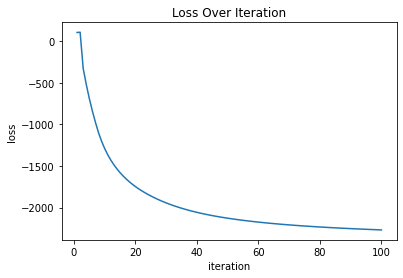

In [9]:
# 绘制学习曲线
loss_plot(loss_list)

接着我们来探究下量子版本的奇异值分解的精度问题。在上述部分，我们提到过可以用分解得到的更少的信息来表达原矩阵。具体来说，就是用前 $T$ 个奇异值和前 $T$ 列左右奇异向量重构一个矩阵：

$$
M_{re}^{(T)} = U_{m \times T} * D_{T \times T} * V^{\dagger}_{T \times m}
$$

并且对于一个本身秩 (rank) 为 $r$ 的矩阵 $M$, 误差随着使用奇异值的数量变多会越来越小。经典的奇异值算法可以保证：

$$
\lim_{T\rightarrow r} ||M - M_{re}^{(T)}||^2_2 = 0
$$

其中矩阵间的距离测量由 2-norm 来计算,

$$
||M||_2 = \sqrt{\sum_{i,j} |M_{ij}|^2}
$$

目前量子版本的奇异值分解还需要很长时间的优化，理论上只能保证上述误差不断减小。

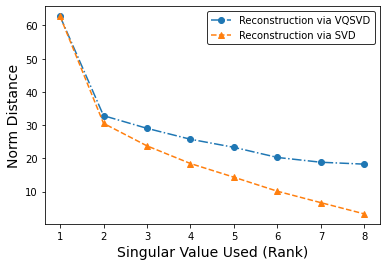

In [10]:
singular_value = singular_value_list[-1]
err_subfull, err_local, err_SVD = [], [], []
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)

# 计算 2-norm 误差
for i in range(T):
    lowrank_mat = np.matrix(U[:, :i]) * np.diag(D[:i])* np.matrix(V_dagger[:i, :])
    recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_value[:i])* np.matrix(V_dagger_learned[:i, :])
    err_local.append(norm(lowrank_mat - recons_mat)) 
    err_subfull.append(norm(M_err - recons_mat))
    err_SVD.append(norm(M_err- lowrank_mat))

# 画图 
fig, ax = plt.subplots()
ax.plot(list(range(1, T+1)), err_subfull, "o-.", label = 'Reconstruction via VQSVD')
ax.plot(list(range(1, T+1)), err_SVD, "^--", label='Reconstruction via SVD')
plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
plt.ylabel('Norm Distance', fontsize = 14)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('k')

### 案例2：图像压缩

为了做图像处理，我们先引入必要的 package。

In [11]:
# 图像处理包 PIL
from PIL import Image

# 打开提前准备好的图片
img = Image.open('./figures/MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)/255

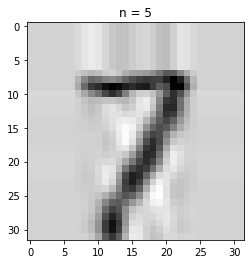

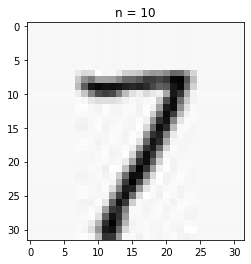

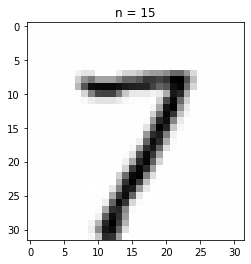

In [12]:
# 然后我们看看经典奇异值的分解效果
U, sigma, V = np.linalg.svd(imgmat)

for i in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

In [21]:
# 然后我们再来看看量子版本的分解效果：
time_start = time.time()

# 超参数设置
N = 5           # 量子比特数量
T = 8           # 设置想要学习的阶数
D = 80          # 量子神经网络的深度
ITR = 200       # 迭代次数
LR = 0.02       # 学习速率
SEED = 14       # 随机数种子

# 设置等差的学习权重
weight = np.arange(2 * T, 0, -2).astype('complex128')


def Mat_generator():
    imgmat = np.array(list(img.getdata(band=0)), float)
    imgmat.shape = (img.size[1], img.size[0])
    lenna = np.matrix(imgmat)
    return lenna.astype('complex128')

M_err = Mat_generator()
U, D, V_dagger = np.linalg.svd(Mat_generator(), full_matrices=True)

In [22]:
# 设置电路参数
cir_depth = 80                           # 电路深度
block_len = 1                            # 每个模组的长度
theta_size = N * block_len * cir_depth   # 网络参数 theta 的大小

# 定义量子神经网络
def U_theta(theta):

    # 用 UAnsatz 初始化网络
    cir = UAnsatz(N)
    
    # 搭建层级结构：
    for layer_num in range(cir_depth):
        
        for which_qubit in range(N):
            cir.ry(theta[block_len * layer_num * N + which_qubit], which_qubit)

        for which_qubit in range(1, N):
            cir.cnot([which_qubit - 1, which_qubit])

    return cir.U

In [23]:
class NET(fluid.dygraph.Layer):
    
    # 初始化长度为 theta_size 的可学习参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
    def __init__(self, shape, param_attr=fluid.initializer.Uniform(low=0.0, high=2 * np.pi), dtype='float64'):
        super(NET, self).__init__()
        
        # 创建用来学习 U 的参数 theta
        self.theta = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
        # 创建用来学习 V_dagger 的参数 phi
        self.phi = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        self.M = fluid.dygraph.to_variable(Mat_generator())
        self.weight = fluid.dygraph.to_variable(weight)

    # 定义损失函数和前向传播机制
    def forward(self):
        
        # 获取量子神经网络的酉矩阵表示
        U = U_theta(self.theta)
        U_dagger = hermitian(U)
        
        
        V = U_theta(self.phi)
        V_dagger = hermitian(V)
        
        # 初始化损失函数和奇异值存储器
        loss = 0 
        singular_values = np.zeros(T)
        
        # 定义损失函数
        for i in range(T):
            loss -= self.weight.real[i] * matmul(U_dagger, matmul(self.M, V)).real[i][i]
            singular_values[i] = (matmul(U_dagger, matmul(self.M, V)).real[i][i]).numpy()
        
        # 函数返回两个矩阵 U 和 V_dagger、 学习的奇异值以及损失函数    
        return U, V_dagger, loss, singular_values

100% |########################################################################|


主程序段总共运行了 871.9080681800842 秒


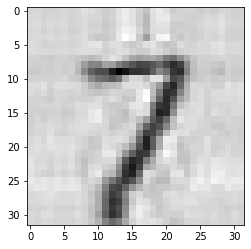

In [24]:
# 记录优化中间过程
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []


# 启动 Paddle 动态图模式
with fluid.dygraph.guard():
    
    net = NET([theta_size])
    # 一般来说，我们利用Adam优化器来获得相对好的收敛，当然你可以改成SGD或者是RMS prop.
    opt = fluid.optimizer.AdagradOptimizer(learning_rate=LR, parameter_list=net.parameters())
    
    # 优化循环
    pbar = ProgressBar()
    for itr in pbar(range(ITR)):
        
        #  前向传播计算损失函数
        U, V_dagger, loss, singular_values = net()
        
        # 在动态图机制下，反向传播极小化损失函数
        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()

        # 记录优化中间结果
        loss_list.append(loss[0][0].numpy())
        singular_value_list.append(singular_values)

    # 记录最后学出的两个酉矩阵    
    U_learned = U.real.numpy() + 1j * U.imag.numpy()
    V_dagger_learned = V_dagger.real.numpy() + 1j*V_dagger.imag.numpy()

singular_value = singular_value_list[-1]
mat = np.matrix(U_learned.real[:, :T]) * np.diag(singular_value[:T])* np.matrix(V_dagger_learned.real[:T, :])

reconstimg = mat
plt.imshow(reconstimg, cmap='gray')

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')

<hr>

## 参考文献：

[1] [Wang, X., Song, Z. & Wang, Y. Variational Quantum Singular Value Decomposition. arXiv:2006.02336 (2020).](https://arxiv.org/abs/2006.02336)